# Using Census Data to Predict Adult Incomes

<b>Research Question:</b> Can we predict which inidiviuals make more than $50,000 per year based on demographic data from the 1994 census?

<b>Data:</b> Data was taken from Kaggle.com and originally extracted from the 1996 Census Bureau Database by Ronny Kohavi and Barry Becker. The data includes individuals that are over the age of 16 and have an Adjusted Gross Income of at least $100 dollars. 

<b>Models</b>: Neural Network & Deep Neural Network 

In [1]:
#=================================================-
#### Directory settings  ####

# Set `main_dir` to the location of your `bah-intermediate` folder (for Mac).
main_dir = '/Users/warrenasfazadour/desktop/bah-intermediate/Capstone'

# Make `data_dir` from the `main_dir` and
# remainder of the path to data directory.
data_dir = main_dir + "/data"



In [2]:
#=================================================-
#### Loading packages  ####

# Silence all warnings 
import warnings
warnings.filterwarnings('ignore')

# Helper packages.
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

# Scikit-learn packages.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

# TensorFlow and supporting packages.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import Dropout



In [3]:
#=================================================-
#### Working directory  ####

# Set working directory.
os.chdir(data_dir)


### Data Exploration & Preparation

In [4]:
#=================================================-
#### Loading data into Python  ####

census = pd.read_csv("adult.csv")
print(census.head())



   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States

In [5]:
#=================================================-
#### The data at first glance  ####

# The data types.
print(census.dtypes)


age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object


In [6]:
#=================================================-
#### Frequency table of the target variable & total Observations  ####

print(census['income'].value_counts())

# Insert a line break
print('\n')

# Total observations
total_observations = len(census)
print('Total Observations: ' + str(total_observations))



<=50K    24720
>50K      7841
Name: income, dtype: int64


Total Observations: 32561


In [7]:
#=================================================-
#### Data prep: check for NAs  ####

# Check for NAs.
#print(census.isnull().sum())

# Replace unknown ('?') information with null
census = census.replace(to_replace='?', value=np.NaN)
print(census.isnull().sum())


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [8]:
#=================================================-
#### Data prep: target  ####

print(census.income.dtypes)
census["income"] = np.where(census["income"] == '>50K', True, False)

# Check class again.
print(census.income.dtypes)
print(census['income'].sum())

object
bool
7841


In [10]:
#=================================================-
#### Working with categorical variables  ####

print(census['marital.status'].value_counts())
print('\n')
print(census['relationship'].value_counts())
print('\n')
print(census['race'].value_counts())
print('\n')
print(census['sex'].value_counts())
print('\n')
print(census['native.country'].value_counts())


Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64


Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


Male      21790
Female    10771
Name: sex, dtype: int64


United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England           

In [11]:
#=================================================-
#### Working with categorical variables  ####

# Consolidate marital status into three categories
census["marital.status"] = np.where((census["marital.status"] == 'Married-civ-spouse') | (census['marital.status'] == 'Married-AF-spouse'), 'Married', np.where(census['marital.status'] == 'Never-married', 'Single', 'Previously-Married'))

print(census['marital.status'].value_counts())

Married               14999
Single                10683
Previously-Married     6879
Name: marital.status, dtype: int64


In [12]:
#=================================================-
#### Transform and replace other categorical variables  ####

# Convert 'marital.status' into dummy variables.
marital_status_dummy = pd.get_dummies(census['marital.status'], drop_first = True)
# Convert 'sex' into dummy variables.
sex_dummy = pd.get_dummies(census['sex'], prefix='sex', drop_first = True)
# Convert 'race' into dummy variables.
race_dummy = pd.get_dummies(census['race'], prefix = 'race', drop_first = True)
# Drop `marital.status` `sex` and `race`from the data.
census.drop(['marital.status', 'sex', 'race'], axis = 1, inplace = True)
# Concatenate `marital.status` `sex_dummy` and `race_dummy` to our dataset.
census = pd.concat([census,marital_status_dummy,sex_dummy,race_dummy],axis=1)
print(census.head())


   age workclass  fnlwgt     education  education.num         occupation  \
0   90       NaN   77053       HS-grad              9                NaN   
1   82   Private  132870       HS-grad              9    Exec-managerial   
2   66       NaN  186061  Some-college             10                NaN   
3   54   Private  140359       7th-8th              4  Machine-op-inspct   
4   41   Private  264663  Some-college             10     Prof-specialty   

    relationship  capital.gain  capital.loss  hours.per.week native.country  \
0  Not-in-family             0          4356              40  United-States   
1  Not-in-family             0          4356              18  United-States   
2      Unmarried             0          4356              40  United-States   
3      Unmarried             0          3900              40  United-States   
4      Own-child             0          3900              40  United-States   

   income  Previously-Married  Single  sex_Male  race_Asian-Pac-Isla

In [13]:
#=================================================-
#### Split into train and test set  ####

# Separate predictors from data.
# We can just drop the target variable, as we are using all other variables as predictors.
X = census.drop(['workclass',
                'hours.per.week',
                'fnlwgt', 
                'education', 
                'occupation', 
                'relationship', 
                'capital.gain', 
                'capital.loss', 
                'native.country',
                'income'], axis = 1)
# Separate target from data.
y = np.array(census['income'])
# Set the seed.
np.random.seed(1)
# Split data into training and test sets, use a 70 train - 30 test split.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3)



In [14]:
#=================================================-
#### Balance target with SMOTE  ####

from imblearn.over_sampling import SMOTE

#Initialize SMOTE object.
smote = SMOTE()

#Fit the sampling method to our train data and labels.
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#Print previous and current target value counts
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train_sm, return_counts=True)
print(dict(zip(unique, counts)))

#Save the oversampled training data back to original variables
X_train, y_train = X_train_sm, y_train_sm

{False: 17352, True: 5440}
{False: 17352, True: 17352}


In [15]:
#=================================================-
#### Create Validation Dataset  ####

# Then split the test data into two halves: test and validation.
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size = .5,
                                                random_state = 1)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape, "Val shape:", X_val.shape)

# Transforms features by scaling each feature to a given range.
# The default is the range between 0 and 1.
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)
X_val_scaled = min_max_scaler.transform(X_val)

Train shape: (34704, 9) Test shape: (4884, 9) Val shape: (4885, 9)


In [49]:
print(y_test.sum())

1195


### General Model Exploration

In [16]:
#=================================================-
#### Implement Sequential model with Dense layers  ####

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Let's set the seed so that we can reproduce the results.
tf.random.set_seed(1)

## Set up model.
model = Sequential([
    Dense(32,                                         #<- number of neurons for 1st hidden layer
          input_shape = (X_train_scaled.shape[1], )), #<- input layer shape: `(num_features, )`
    Dense(20,                                         #<- add 2nd hidden layer with 20 neurons
          activation = 'relu'), #<- set activation function for hidden layer
    Dense(1,                    #<- add output layer with single neuron
          activation = 'sigmoid')#<- activation function for output layer
])



In [17]:
#=================================================-
#### Compile the model  ####

# Compile the model.
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])


In [18]:
#=================================================-
#### Fit the model  ####

model_res = model.fit(X_train_scaled, y_train,                 #<- train data and labels
                      validation_data = (X_val_scaled, y_val), #<- pass val data
                      epochs = 200)                            #<- number of epochs


Epoch 1/200
1085/1085 [==============================] - 2s 1ms/step - loss: 0.4622 - accuracy: 0.7866 - val_loss: 0.4385 - val_accuracy: 0.7556
Epoch 2/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4262 - accuracy: 0.8018 - val_loss: 0.4399 - val_accuracy: 0.7566
Epoch 3/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4228 - accuracy: 0.8052 - val_loss: 0.4430 - val_accuracy: 0.7605
Epoch 4/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4183 - accuracy: 0.8075 - val_loss: 0.4521 - val_accuracy: 0.7613
Epoch 5/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4153 - accuracy: 0.8097 - val_loss: 0.4548 - val_accuracy: 0.7629
Epoch 6/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4126 - accuracy: 0.8102 - val_loss: 0.4384 - val_accuracy: 0.7703
Epoch 7/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4120 - accuracy: 0.8117 - val_loss: 0.4378 - val_ac

Epoch 57/200
1085/1085 [==============================] - 1s 925us/step - loss: 0.4075 - accuracy: 0.8146 - val_loss: 0.4381 - val_accuracy: 0.7693
Epoch 58/200
1085/1085 [==============================] - 1s 911us/step - loss: 0.4069 - accuracy: 0.8147 - val_loss: 0.4512 - val_accuracy: 0.7687
Epoch 59/200
1085/1085 [==============================] - 1s 918us/step - loss: 0.4074 - accuracy: 0.8157 - val_loss: 0.4266 - val_accuracy: 0.7787
Epoch 60/200
1085/1085 [==============================] - 1s 985us/step - loss: 0.4071 - accuracy: 0.8147 - val_loss: 0.4438 - val_accuracy: 0.7689
Epoch 61/200
1085/1085 [==============================] - 1s 942us/step - loss: 0.4073 - accuracy: 0.8141 - val_loss: 0.4314 - val_accuracy: 0.7738
Epoch 62/200
1085/1085 [==============================] - 1s 918us/step - loss: 0.4067 - accuracy: 0.8148 - val_loss: 0.4315 - val_accuracy: 0.7748
Epoch 63/200
1085/1085 [==============================] - 1s 993us/step - loss: 0.4073 - accuracy: 0.8152 - val_

1085/1085 [==============================] - 1s 907us/step - loss: 0.4054 - accuracy: 0.8156 - val_loss: 0.4202 - val_accuracy: 0.7789
Epoch 113/200
1085/1085 [==============================] - 1s 975us/step - loss: 0.4050 - accuracy: 0.8146 - val_loss: 0.4587 - val_accuracy: 0.7613
Epoch 114/200
1085/1085 [==============================] - 1s 973us/step - loss: 0.4050 - accuracy: 0.8153 - val_loss: 0.4361 - val_accuracy: 0.7654
Epoch 115/200
1085/1085 [==============================] - 1s 974us/step - loss: 0.4054 - accuracy: 0.8143 - val_loss: 0.4220 - val_accuracy: 0.7789
Epoch 116/200
1085/1085 [==============================] - 1s 975us/step - loss: 0.4050 - accuracy: 0.8147 - val_loss: 0.4563 - val_accuracy: 0.7640
Epoch 117/200
1085/1085 [==============================] - 1s 984us/step - loss: 0.4051 - accuracy: 0.8150 - val_loss: 0.4397 - val_accuracy: 0.7720
Epoch 118/200
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4050 - accuracy: 0.8139 - val_loss: 0.4

1085/1085 [==============================] - 1s 918us/step - loss: 0.4045 - accuracy: 0.8154 - val_loss: 0.4241 - val_accuracy: 0.7789
Epoch 168/200
1085/1085 [==============================] - 1s 912us/step - loss: 0.4045 - accuracy: 0.8149 - val_loss: 0.4511 - val_accuracy: 0.7652
Epoch 169/200
1085/1085 [==============================] - 1s 978us/step - loss: 0.4044 - accuracy: 0.8154 - val_loss: 0.4323 - val_accuracy: 0.7752
Epoch 170/200
1085/1085 [==============================] - 1s 944us/step - loss: 0.4045 - accuracy: 0.8149 - val_loss: 0.4277 - val_accuracy: 0.7765
Epoch 171/200
1085/1085 [==============================] - 1s 921us/step - loss: 0.4045 - accuracy: 0.8152 - val_loss: 0.4217 - val_accuracy: 0.7818
Epoch 172/200
1085/1085 [==============================] - 1s 992us/step - loss: 0.4046 - accuracy: 0.8153 - val_loss: 0.4227 - val_accuracy: 0.7826
Epoch 173/200
1085/1085 [==============================] - 1s 947us/step - loss: 0.4046 - accuracy: 0.8147 - val_loss: 0

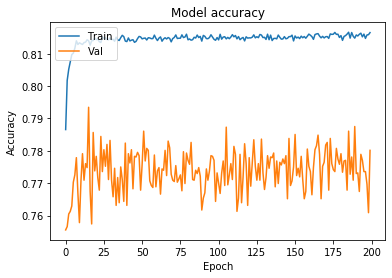

In [19]:
#=================================================-
#### Visualize training/validation accuracy for each epoch  ####

# Plot training & validation accuracy values
plt.plot(model_res.history['accuracy'])    #<- accuracy scores
plt.plot(model_res.history['val_accuracy'])#<- get val accuracy scores from dictionary
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


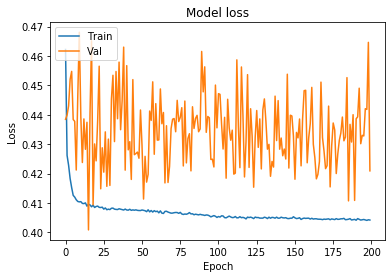

In [20]:
#=================================================-
#### Visualize training/validation loss for each epoch  ####

# Plot training & validation loss values
plt.plot(model_res.history['loss'])
plt.plot(model_res.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
#=================================================-
#### Slide 39: Evaluate loss, accuracy on test data and predict  ####

print(model.evaluate(X_test_scaled, y_test))

y_pred_prob = model.predict(X_test_scaled)
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
print(y_pred_prob)


153/153 [==============================] - 0s 691us/step - loss: 0.4169 - accuracy: 0.7832
[0.4168548882007599, 0.7831695079803467]
[[0.6964464 ]
 [0.79280305]
 [0.84806085]
 ...
 [0.12591887]
 [0.36392474]
 [0.58520937]]


In [22]:
#=================================================-
#### Define and compile a sequential model  ####

def create_model(lr = .01):
    # Let's set the seed so that we can reproduce the results.
    tf.random.set_seed(1)
    opt = Adam(learning_rate = lr) # <- set optimizer

    model = Sequential([
        Dense(32, activation='relu', input_dim=9),#<- set input and 1st hidden layer
        Dense(32, activation='relu'),              #<- set 2nd hidden layer
        Dense(1, activation='sigmoid')             #<- set output layer
    ])

    model.compile(optimizer = opt,            #<- set optimizer
                  loss='binary_crossentropy', #<- set loss function to binary_crossentropy
                  metrics=['accuracy'])       #<- set performance metric
    
    return model


In [23]:
#=================================================-
#### Default learning rate  ####

lr_default = create_model().fit(X_train_scaled, y_train,
                                epochs = 25,
                                validation_data=(X_val_scaled,y_val))


Epoch 1/25
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4393 - accuracy: 0.7975 - val_loss: 0.4462 - val_accuracy: 0.7683
Epoch 2/25
1085/1085 [==============================] - 1s 952us/step - loss: 0.4208 - accuracy: 0.8078 - val_loss: 0.4396 - val_accuracy: 0.7724
Epoch 3/25
1085/1085 [==============================] - 1s 949us/step - loss: 0.4179 - accuracy: 0.8097 - val_loss: 0.4878 - val_accuracy: 0.7437
Epoch 4/25
1085/1085 [==============================] - 1s 931us/step - loss: 0.4164 - accuracy: 0.8104 - val_loss: 0.4140 - val_accuracy: 0.7826
Epoch 5/25
1085/1085 [==============================] - 1s 964us/step - loss: 0.4164 - accuracy: 0.8120 - val_loss: 0.5023 - val_accuracy: 0.7494
Epoch 6/25
1085/1085 [==============================] - 1s 931us/step - loss: 0.4145 - accuracy: 0.8101 - val_loss: 0.4748 - val_accuracy: 0.7533
Epoch 7/25
1085/1085 [==============================] - 1s 939us/step - loss: 0.4139 - accuracy: 0.8118 - val_loss: 0.4405 - v

In [24]:
#=================================================-
#### High learning rate  ####

# Set learning rate to 0.75.
lr_high = create_model(lr = .75).fit(X_train_scaled, y_train,
                                     epochs = 25,
                                     validation_data=(X_val_scaled, y_val))



Epoch 1/25
1085/1085 [==============================] - 1s 1ms/step - loss: 0.8303 - accuracy: 0.5005 - val_loss: 0.8222 - val_accuracy: 0.2469
Epoch 2/25
1085/1085 [==============================] - 1s 926us/step - loss: 0.7070 - accuracy: 0.5016 - val_loss: 0.7818 - val_accuracy: 0.2469
Epoch 3/25
1085/1085 [==============================] - 1s 932us/step - loss: 0.7066 - accuracy: 0.4997 - val_loss: 0.7307 - val_accuracy: 0.2469
Epoch 4/25
1085/1085 [==============================] - 1s 935us/step - loss: 0.7055 - accuracy: 0.5036 - val_loss: 0.6434 - val_accuracy: 0.7531
Epoch 5/25
1085/1085 [==============================] - 1s 930us/step - loss: 0.7055 - accuracy: 0.5018 - val_loss: 0.6835 - val_accuracy: 0.7531
Epoch 6/25
1085/1085 [==============================] - 1s 1ms/step - loss: 0.7070 - accuracy: 0.5033 - val_loss: 0.6934 - val_accuracy: 0.2469
Epoch 7/25
1085/1085 [==============================] - 1s 942us/step - loss: 0.7047 - accuracy: 0.4994 - val_loss: 0.6908 - val

In [25]:
#=================================================-
#### Low learning rate  ####

lr_low = create_model(lr=.0001).fit(X_train_scaled, y_train,
                                    epochs = 50, #<- increase the number of epochs
                                    validation_data=(X_val_scaled, y_val))



Epoch 1/50
1085/1085 [==============================] - 1s 1ms/step - loss: 0.6243 - accuracy: 0.6926 - val_loss: 0.5593 - val_accuracy: 0.7271
Epoch 2/50
1085/1085 [==============================] - 1s 910us/step - loss: 0.4901 - accuracy: 0.7856 - val_loss: 0.4923 - val_accuracy: 0.7288
Epoch 3/50
1085/1085 [==============================] - 1s 949us/step - loss: 0.4542 - accuracy: 0.7921 - val_loss: 0.4766 - val_accuracy: 0.7402
Epoch 4/50
1085/1085 [==============================] - 251s 231ms/step - loss: 0.4424 - accuracy: 0.7971 - val_loss: 0.4664 - val_accuracy: 0.7460
Epoch 5/50
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4356 - accuracy: 0.7987 - val_loss: 0.4668 - val_accuracy: 0.7503
Epoch 6/50
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4318 - accuracy: 0.8005 - val_loss: 0.4453 - val_accuracy: 0.7578
Epoch 7/50
1085/1085 [==============================] - 1s 1ms/step - loss: 0.4294 - accuracy: 0.8016 - val_loss: 0.4475 - val_a

In [26]:
#=================================================-
#### Visualize results for learning rates  ####

learn_rates = []

for exp, result in zip([lr_default, lr_low, lr_high], [".01", ".0001", ".75"]):

    df = pd.DataFrame.from_dict(exp.history)
    df['epoch'] = df.index.values
    df['Learning Rate'] = result

    learn_rates.append(df)

    df_learning = pd.concat(learn_rates)
    df_learning['Learning Rate'] = df_learning['Learning Rate'].astype('str')
    


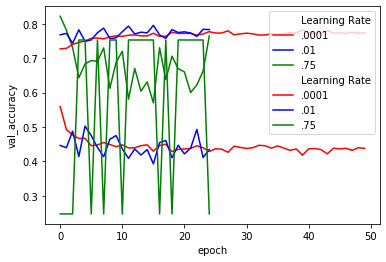

In [27]:
#=================================================-
#### Visualize results for learning rates (cont'd)  ####

sns.lineplot(x='epoch', y='val_loss', hue='Learning Rate', palette=["r", "b", 'g'], data=df_learning)
sns.lineplot(x='epoch', y='val_accuracy', hue='Learning Rate', palette=["r", "b", 'g'], data=df_learning)


In [28]:
#=================================================-
#### Activity  ####

model = create_model()
bt_small = model.fit(X_train_scaled, y_train,                   #<- train data and labels
                     epochs = 25,                              #<- number of epochs
                     batch_size= 8,                            #<- set batch_size
                     validation_data = (X_val_scaled, y_val))  #<- pass val data



Epoch 1/25
4338/4338 [==============================] - 4s 867us/step - loss: 0.4370 - accuracy: 0.7994 - val_loss: 0.4376 - val_accuracy: 0.7742
Epoch 2/25
4338/4338 [==============================] - 4s 818us/step - loss: 0.4231 - accuracy: 0.8075 - val_loss: 0.4465 - val_accuracy: 0.7699
Epoch 3/25
4338/4338 [==============================] - 4s 817us/step - loss: 0.4214 - accuracy: 0.8079 - val_loss: 0.4775 - val_accuracy: 0.7523
Epoch 4/25
4338/4338 [==============================] - 4s 822us/step - loss: 0.4199 - accuracy: 0.8108 - val_loss: 0.4047 - val_accuracy: 0.7824
Epoch 5/25
4338/4338 [==============================] - 4s 817us/step - loss: 0.4173 - accuracy: 0.8108 - val_loss: 0.4401 - val_accuracy: 0.7715
Epoch 6/25
4338/4338 [==============================] - 4s 826us/step - loss: 0.4174 - accuracy: 0.8090 - val_loss: 0.4585 - val_accuracy: 0.7474
Epoch 7/25
4338/4338 [==============================] - 4s 818us/step - loss: 0.4165 - accuracy: 0.8105 - val_loss: 0.4461 -

In [29]:
#=================================================-
#### Select metrics  ####

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]



### Creating the Baseline Model

In [30]:
#=================================================-
#### Define the model and compile it  ####

def create_model(lr = .75):
    # Let's set the seed so that we can reproduce the results.
    tf.random.set_seed(1)
    opt = Adam(learning_rate = lr) # <- set optimizer

    model = Sequential([
        Dense(32, activation='relu',
              input_dim = X_train_scaled.shape[1]),#<- set input and 1st hidden layer
        Dense(32, activation='relu'),              #<- set 2nd hidden layer
        Dense(1, activation='sigmoid')             #<- set output layer
    ])

    model.compile(optimizer = opt,            #<- set optimizer
                  loss='binary_crossentropy', #<- set loss function to binary_crossentropy
                  metrics= METRICS)           #<- set performance metric
    return model


In [31]:
#=================================================-
#### Fit baseline model  ####

# Create baseline model.
model = create_model()

# Fit baseline model to training data.
model_default = model.fit(X_train_scaled, y_train,
                          epochs = 25,
                          validation_data = (X_val_scaled, y_val),
                          verbose = 2)



Epoch 1/25
1085/1085 - 3s - loss: 0.8303 - tp: 8593.0000 - fp: 8574.0000 - tn: 8778.0000 - fn: 8759.0000 - accuracy: 0.5005 - precision: 0.5006 - recall: 0.4952 - auc: 0.5012 - val_loss: 0.8222 - val_tp: 1206.0000 - val_fp: 3679.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2469 - val_precision: 0.2469 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/25
1085/1085 - 1s - loss: 0.7070 - tp: 8532.0000 - fp: 8476.0000 - tn: 8876.0000 - fn: 8820.0000 - accuracy: 0.5016 - precision: 0.5016 - recall: 0.4917 - auc: 0.5029 - val_loss: 0.7818 - val_tp: 1206.0000 - val_fp: 3679.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2469 - val_precision: 0.2469 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/25
1085/1085 - 1s - loss: 0.7066 - tp: 8419.0000 - fp: 8429.0000 - tn: 8923.0000 - fn: 8933.0000 - accuracy: 0.4997 - precision: 0.4997 - recall: 0.4852 - auc: 0.5001 - val_loss: 0.7307 - val_tp: 1206.0000 - val_fp: 3679.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 

Epoch 24/25
1085/1085 - 1s - loss: 0.7083 - tp: 9119.0000 - fp: 9025.0000 - tn: 8327.0000 - fn: 8233.0000 - accuracy: 0.5027 - precision: 0.5026 - recall: 0.5255 - auc: 0.5013 - val_loss: 0.6621 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3679.0000 - val_fn: 1206.0000 - val_accuracy: 0.7531 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 25/25
1085/1085 - 1s - loss: 0.7062 - tp: 8525.0000 - fp: 8611.0000 - tn: 8741.0000 - fn: 8827.0000 - accuracy: 0.4975 - precision: 0.4975 - recall: 0.4913 - auc: 0.4972 - val_loss: 0.7649 - val_tp: 1206.0000 - val_fp: 3679.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.2469 - val_precision: 0.2469 - val_recall: 1.0000 - val_auc: 0.5000


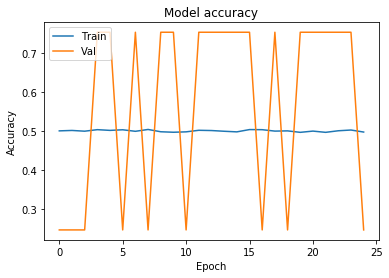

In [32]:
#=================================================-
#### Visualize training/validation results  ####

# Plot training & validation accuracy values
plt.plot(model_default.history['accuracy'])    #<- accuracy scores
plt.plot(model_default.history['val_accuracy'])#<- get val accuracy scores from dictionary
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [33]:
#=================================================-
#### Evaluate model on test data  ####

model.evaluate(X_test_scaled, y_test)



153/153 [==============================] - 0s 1ms/step - loss: 0.7654 - tp: 1195.0000 - fp: 3689.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2447 - precision: 0.2447 - recall: 1.0000 - auc: 0.5001


[0.7654488682746887,
 1195.0,
 3689.0,
 0.0,
 0.0,
 0.24467650055885315,
 0.24467650055885315,
 1.0,
 0.5001355409622192]

### Tuning an Artifical Neural Network

In [34]:
#=================================================-
#### Function to tune hyperparameters  ####

def tune_model(hp):

    # Number of 1st hidden layer neurons.
    units = hp.Int('units',        #<- Number of neurons
                   min_value = 8,  #<- min value
                   max_value = 64, #<- max value
                   step = 8)

    # Tuning activation function for 1st hidden layer.
    activation = hp.Choice('activation', #<- Activation function
                           [             #<- Types of activation functions
                               'relu',
                               'tanh',
                               'sigmoid'
                           ])

    dropout_1 = hp.Float('dropout_1',
                         min_value = 0.0,
                         max_value = 0.5,
                         default = 0.25,
                         step = 0.05)

    # Tuning optimizer.
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    # Tuning learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    model = keras.Sequential()

    model.add(keras.layers.Dense(units = units,
                             activation = activation,
                             input_dim = X_train_scaled.shape[1]))

    # Tuning number of neurons in 2nd hidden layer
    model.add(keras.layers.Dense(units = units,
                             activation = activation))

    # Tuning rate hyperparameter of dropout layer
    model.add(Dropout(rate = dropout_1))

    # Add output layer
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

    # Compile model.
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = METRICS)

    return model


In [35]:
#=================================================-
#### Define the tuner  ####

MAX_TRIALS = 10
EXECUTIONS_PER_TRIAL = 5
tuner = RandomSearch(
    tune_model,
    objective = 'val_accuracy',
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTIONS_PER_TRIAL,
    directory = 'final_tuned_model',
    project_name = 'final_tuned_model',
    seed = 1
)


In [36]:
#=================================================-
#### View search space summary  ####

tuner.search_space_summary()


Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [37]:
#=================================================-
#### Tuning the model  ####

tuner.search(x=X_train_scaled,
             y=y_train,
             verbose=1,
             epochs=25,
             validation_data=(X_val_scaled, y_val))
optimal_params = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
optimal_params


Trial 10 Complete [00h 03m 23s]
val_accuracy: 0.7952916979789734

Best val_accuracy So Far: 0.7981576204299927
Total elapsed time: 00h 36m 26s
INFO:tensorflow:Oracle triggered exit


{'units': 56,
 'activation': 'tanh',
 'dropout_1': 0.1,
 'optimizer': 'sgd',
 'learning_rate': 0.0001}

In [38]:
#=================================================-
#### Define and compile optimized model  ####

def create_optimized_model(units,
                           activation,
                           dropout_1,
                           optimizer,
                           learning_rate,
                           dropout_seed = 1):

    # Set up model.
    model = Sequential()

    model.add(Dense(units,
                    input_dim = X_train_scaled.shape[1],
                    activation = activation))
    model.add(Dense(units,
                    activation = activation))

    if dropout_1 is not None:
        model.add(Dropout(rate = dropout_1, seed = dropout_seed))
        model.add(Dense(1, activation = 'sigmoid'))

    # Compile model.
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = METRICS)
    return model


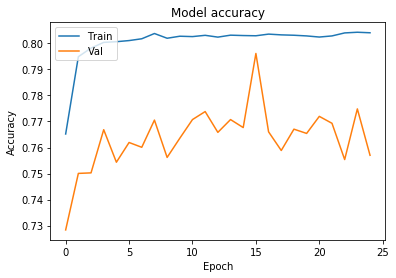

In [39]:
#=================================================-
#### Fit the optimized model and visualize results  ####

# Create and compile the optimized model.
tb_model = create_optimized_model(**optimal_params)

tb_model_ex = tb_model.fit(X_train_scaled,
                        y_train,
                        validation_data = (X_val_scaled, y_val),
                        epochs = 25,
                        verbose = 0)          #<- silence the epoch output in console (optional)

# Plot training & validation accuracy values
plt.plot(tb_model_ex.history['accuracy'])    #<- accuracy scores
plt.plot(tb_model_ex.history['val_accuracy'])#<- get val accuracy scores from dictionary
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [40]:
#=================================================-
#### Compare and evaluate on test data  ####
print(tb_model.evaluate(X_train_scaled, y_train))

print(tb_model.evaluate(X_test_scaled, y_test))



1085/1085 [==============================] - 1s 1ms/step - loss: 0.4261 - tp: 15380.0000 - fp: 4907.0000 - tn: 12445.0000 - fn: 1972.0000 - accuracy: 0.8018 - precision: 0.7581 - recall: 0.8864 - auc: 0.8804s - loss: 0.4727 - tp: 2575.0000 - fp: 2786.0000 - tn: 7010.0000 - fn: 461.0000 - accuracy: 0.7470 - precision: 0.4803 - reca
[0.42614251375198364, 15380.0, 4907.0, 12445.0, 1972.0, 0.8017807602882385, 0.7581209540367126, 0.8863531351089478, 0.880440890789032]
153/153 [==============================] - 0s 1ms/step - loss: 0.4568 - tp: 1032.0000 - fp: 1006.0000 - tn: 2683.0000 - fn: 163.0000 - accuracy: 0.7606 - precision: 0.5064 - recall: 0.8636 - auc: 0.8709
[0.45677056908607483, 1032.0, 1006.0, 2683.0, 163.0, 0.7606469988822937, 0.5063788294792175, 0.8635983467102051, 0.870875895023346]


### Tuning a Deep Neural Network

In [41]:
#=================================================-
#### Function to tune hyperparameters  ####

def tune_model_deep(hp):

    # Number of 1st hidden layer neurons.
    units_first = hp.Int('units_first',        #<- Number of neurons
                   min_value = 8,  #<- min value
                   max_value = 64, #<- max value
                   step = 8)
    
    units_second = hp.Int('units_second',        #<- Number of neurons
                   min_value = 8,  #<- min value
                   max_value = 64, #<- max value
                   step = 8)
    
    units_third = hp.Int('units_third',        #<- Number of neurons
                   min_value = 8,  #<- min value
                   max_value = 64, #<- max value
                   step = 8)

    # Tuning activation function for 1st hidden layer.
    activation = hp.Choice('activation', #<- Activation function
                           [             #<- Types of activation functions
                               'relu',
                               'tanh',
                               'sigmoid'
                           ])

    dropout_1 = hp.Float('dropout_1',
                         min_value = 0.0,
                         max_value = 0.5,
                         default = 0.25,
                         step = 0.05)

    # Tuning optimizer.
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    # Tuning learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    model = keras.Sequential()

    model.add(keras.layers.Dense(units = units_first,
                             activation = activation,
                             input_dim = X_train_scaled.shape[1]))

    # Tuning number of neurons in 2nd hidden layer
    model.add(keras.layers.Dense(units = units_second,
                             activation = activation))
    
    # Tuning number of neurons in 3nd hidden layer
    model.add(keras.layers.Dense(units = units_third,
                             activation = activation))

    # Tuning rate hyperparameter of dropout layer
    model.add(Dropout(rate = dropout_1))

    # Add output layer
    model.add(keras.layers.Dense(1, activation = 'sigmoid'))

    # Compile model.
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = METRICS)

    return model


In [42]:
#=================================================-
#### Define the tuner  ####

MAX_TRIALS = 10
EXECUTIONS_PER_TRIAL = 5
tuner = RandomSearch(
    tune_model_deep,
    objective = 'val_accuracy',
    max_trials = MAX_TRIALS,
    executions_per_trial = EXECUTIONS_PER_TRIAL,
    directory = 'final_tuned_model',
    project_name = 'final_tuned_model_deep',
    seed = 1
)

In [43]:
#=================================================-
#### View search space summary  ####

tuner.search_space_summary()


Search space summary
Default search space size: 7
units_first (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
units_second (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
units_third (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [44]:
#=================================================-
#### Tuning the model  ####

tuner.search(x=X_train_scaled,
             y=y_train,
             verbose=1,
             epochs=25,
             validation_data=(X_val_scaled, y_val))
optimal_params_deep = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
optimal_params_deep

Trial 10 Complete [00h 03m 23s]
val_accuracy: 0.796356201171875

Best val_accuracy So Far: 0.8074513912200928
Total elapsed time: 00h 33m 21s
INFO:tensorflow:Oracle triggered exit


{'units_first': 8,
 'units_second': 40,
 'units_third': 24,
 'activation': 'tanh',
 'dropout_1': 0.25,
 'optimizer': 'rmsprop',
 'learning_rate': 0.001}

In [45]:
#=================================================-
#### Define and compile optimized model  ####

def create_optimized_model_deep(units_first,
                           units_second,
                           units_third,
                           activation,
                           dropout_1,
                           optimizer,
                           learning_rate,
                           dropout_seed = 1):

    # Set up model.
    model = Sequential()

    model.add(Dense(units_first,
                    input_dim = X_train_scaled.shape[1],
                    activation = activation))
    model.add(Dense(units_second,
                    activation = activation))
    model.add(Dense(units_third,
                    activation = activation))

    if dropout_1 is not None:
        model.add(Dropout(rate = dropout_1, seed = dropout_seed))
        model.add(Dense(1, activation = 'sigmoid'))

    # Compile model.
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = METRICS)
    return model

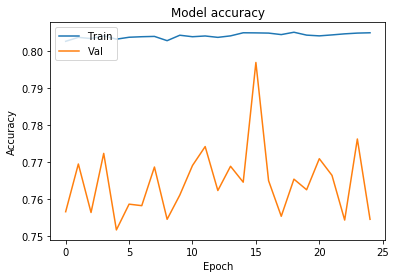

In [46]:
#=================================================-
#### Fit the optimized model and visualize results  ####

# Create and compile the optimized model.
tb_model_deep = create_optimized_model_deep(**optimal_params_deep)

tb_model_deep_ex = tb_model.fit(X_train_scaled,
                        y_train,
                        validation_data = (X_val_scaled, y_val),
                        epochs = 25,
                        verbose = 0)          #<- silence the epoch output in console

# Plot training & validation accuracy values
plt.plot(tb_model_deep_ex.history['accuracy'])    #<- accuracy scores
plt.plot(tb_model_deep_ex.history['val_accuracy'])#<- get val accuracy scores from dictionary
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [75]:
#=================================================-
#### Compare and evaluate on test data  ####
print(tb_model_deep.evaluate(X_train_scaled, y_train))

print(tb_model_deep.evaluate(X_test_scaled, y_test))


1085/1085 [==============================] - 1s 1ms/step - loss: 0.6595 - tp: 16567.0000 - fp: 10180.0000 - tn: 7172.0000 - fn: 785.0000 - accuracy: 0.6840 - precision: 0.6194 - recall: 0.9548 - auc: 0.78820s - loss: 0.6833 - tp: 2634.0000 - fp: 5340.0000 - tn: 3746.0000 - fn: 184.0000 - accuracy: 0.5360 - precision: 0.3303 - re
[0.6594558358192444, 16567.0, 10180.0, 7172.0, 785.0, 0.6840421557426453, 0.6193965673446655, 0.9547602534294128, 0.7881820797920227]
153/153 [==============================] - 0s 1ms/step - loss: 0.6814 - tp: 1119.0000 - fp: 2134.0000 - tn: 1555.0000 - fn: 76.0000 - accuracy: 0.5475 - precision: 0.3440 - recall: 0.9364 - auc: 0.7814
[0.6813978552818298, 1119.0, 2134.0, 1555.0, 76.0, 0.5475020408630371, 0.34399017691612244, 0.9364016652107239, 0.7814227342605591]


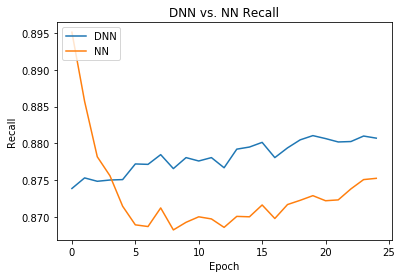

In [69]:
# Plot NN vs. DNN Recall
plt.plot(tb_model_deep_ex.history['recall'])#<- recall for DNN tuned 
plt.plot(tb_model_ex.history['recall'])#<- get recall for NN tuned

plt.title('DNN vs. NN Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DNN', 'NN'], loc='upper left')
plt.show()

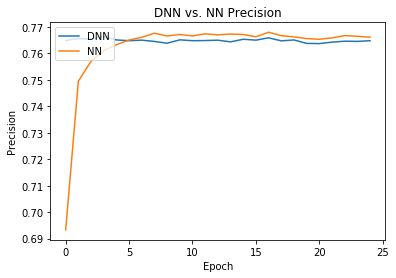

In [73]:
# Plot NN vs. DNN Precision
plt.plot(tb_model_deep_ex.history['precision'])#<- recall for DNN tuned 
plt.plot(tb_model_ex.history['precision'])#<- get recall for NN tuned

plt.title('DNN vs. NN Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DNN', 'NN'], loc='upper left')
plt.show()

## Conclusions

Both tuned models perfermed well in terms of recall, however the Deep Neural Network did not have great precision. Meaning the DNN model is good at minimizing false positives, but not good at minimizing false positives. With that sad the simple Neural Network performed well on both precision and recall and therefore would be the better model of the two. 

With more time I would look deeper into optimizing the precision vs. recall trade off. 